In [1]:
#Notebook to calculate change in LW CRE on a monthly basis, 
#analogous to "MonthlyKernels.ipynb" but for this quantity.

#Requires correction for cloud masking of all the other kernel-derived quantities. 

#Rick Russotto, started 18 October 2019

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
#Load climatological files for surface temperature baseline and pressure levels
ds_clim_2D = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')
ds_clim_for_plevs = xr.open_dataset('../nc_ta/master_ta.nc').sel(exp='AquaControl')

In [4]:
#Names of models in CMORized climate model output files
model_filenames = {'AM2': 'AM21', 
                   'CAM3': 'CAM3', 
                   'CAM4': 'CAM4',
                   'CNRM-AM6-DIA-v2': 'CNRM-AM5', 
                   'ECHAM-6.1': 'ECHAM61', 
                   'ECHAM-6.3': 'ECHAM63', 
                   'GISS-ModelE2': 'GISS-ModelE2',
                   'IPSL-CM5A': 'LMDZ5A', 
                   'MIROC5': 'MIROC5', 
                   'MPAS': 'MPAS', 
                   'MetUM-GA6-CTL': 'MetUM-CTL', 
                   'MetUM-GA6-ENT': 'MetUM-ENT', 
                   'NorESM2': 'CAM5Nor'}

In [5]:
#Models for which this works 
#Skip NorESM2--no LW clear-sky radiation
#Skip CNRM--had zero values of water vapor
models_10 = ['AM2', 'CAM3', 'CAM4', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 
             'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT']

In [6]:
#Calculate pressure level differences/layer thicknesses
plev = ds_clim_for_plevs.plev.data
plev_mp = (plev[1:]+plev[:-1])/2 #Calculate midpoints
plev_mp0 = np.insert(plev_mp,0,0) #Add TOA boundary
#Extend 2nd-to-last layer all the way to ground (drop last layer when accessing data)
plev_mp0[-1] = 101325
plev_widths = np.diff(plev_mp0)
print(plev_widths) #should be what's listed below:
#[ 1500.  1000.  1500.  2000.  2500.  4000.  5000.  5000.  5000.  7500.
# 10000. 10000. 10000. 12500. 11250. 12575.]

[ 1500.  1000.  1500.  2000.  2500.  4000.  5000.  5000.  5000.  7500.
 10000. 10000. 10000. 12500. 11250. 12575.]


In [17]:
#OK, need a plan.

#Need Gregory regression for the the change in LW cloud radiative effect, 
#both raw (not necessary really but useful diagnostic) and corrected for cloud masking

#List of tasks that need to be done (figure out order later):

# -Load the monthly data for OLR, clear-sky OLR, surface temperature, atmospheric temperature, and specific humidity
# -Load the all-sky and clear-sky surface temperature, atmospheric temperature, and water vapor kernels
# -Load the correction for the CO2 kernel calculated in "ApplyKernels_cloudLW"
# -Calculate the change in CRE in each month
# -Regrid to the common climatology grid for the models (when did I do this again?)
# -Regress the uncorrected and corrected CRE change against surface temperature chagne
# -Make plots showing the rapid adjustment and feedback in the zonal mean

In [18]:
#What to do first?
#Load the kernels?
#Had regridded the kernels to the specific model grids, multiplying by the monthly data before 
#regridding to the common climatology grid. Loaded these kernels in a loop. 
#But for the surface temperature kernel, did the whole thing on the common climatology grid. 

#Way I think this should be done: 
#Calculate the change in LWCRE and each of the 3 kernel corrections (plus yearly duplication of the CO2 correction)
#in separate loops over the months, some of which regrid to common climatology grids. 
#Then put everything together,
#and do the regressions.


In [19]:
#Have I done the "original grid" (og) kernel regridding for the clear sky cases?
#Yes, I did. 


In [20]:

#####   LWCRE CALCULATION IN EACH MONTH   #####


In [33]:
#Can I just subtract clear-sky from all-sky OLR directly from the monthly output?
#Should be able to, but still want to take zonal means and regrid to the common grid
#Also, in order to calculate a CHANGE in LWCRE, still need to load the climatology
#Maybe not zonal mean yet--seems better to apply the corrections on the longitudes, then do that.

#Remember: different lengths of time for each model means I can't create a single XArray 
#dataset before actually doing the regressions

In [32]:
dLWCRE_raw = dict()
for model in models_10:
    print('calculating change in LWCRE: ' + model)
    
    #Load the monthly data
    ds_mon_rlut = xr.open_dataset(glob.glob('../nc_esgf/Amon/rlut_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_rlutcs = xr.open_dataset(glob.glob('../nc_esgf/Amon/rlutcs_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    #OK, confirmed I could load everything. These have time, lat, lon dimensions
    
    LWCRE_mon = ds_mon_rlutcs['rlutcs'] - ds_mon_rlut['rlut']
    print(np.shape(LWCRE_mon))
    
    
    #Calculate LWCRE change in the climatology
    LWCRE_cli = ds_clim_2D['rlutcs'].sel(model=model) - ds_clim_2D['rlut'].sel(model=model) 
    print(np.shape(LWCRE_cli)) #(12, 180, 180)
    LWCRE_cli_zm = LWCRE_cli.mean(dim='lon')
    
    
    #Regrid the monthly result to the climatology grid
    #This has to be done in 2D, difficult...
    #maybe I should just take the zonal mean first 
    #Yes, I'll do this. 
    #The interpolation takes a bit of time--save to NetCDF file?
    LWCRE_mon_zm = LWCRE_mon.mean(dim='lon')
    LWCRE_mon_rg = LWCRE_mon_zm.interp(coords = {'time': LWCRE_mon_zm.time.data, 'lat': LWCRE_cli_zm.lat.data})
    print(np.shape(LWCRE_mon_rg))
    
    #Duplicate the climatology to have the same time dimensions as the monthly stuff
    numYears = int(len(LWCRE_mon.time)/12.)
    LWCRE_cli_raw = LWCRE_cli_zm.data
    LWCRE_cli_dupe = np.tile(LWCRE_cli_raw, (numYears,1))
    print(np.shape(LWCRE_cli_dupe))
    
    #Take difference
    dLWCRE_raw[model] = LWCRE_mon_rg - LWCRE_cli_dupe
    
    #Save to NetCDF file for reference in other scripts
    dLWCRE_raw[model].to_netcdf('nc_from_xarray/dLWCRE_raw_monthly_'+model+'.nc')
    

calculating change in LWCRE: AM2
(480, 90, 144)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: CAM3
(480, 64, 128)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: CAM4
(480, 96, 144)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: ECHAM-6.1
(540, 96, 192)
(12, 180, 180)
(540, 180)
(540, 180)
calculating change in LWCRE: ECHAM-6.3
(480, 96, 192)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: IPSL-CM5A
(360, 96, 96)
(12, 180, 180)
(360, 180)
(360, 180)
calculating change in LWCRE: MIROC5
(480, 128, 256)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: MPAS
(480, 96, 144)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: MetUM-GA6-CTL
(480, 144, 192)
(12, 180, 180)
(480, 180)
(480, 180)
calculating change in LWCRE: MetUM-GA6-ENT
(480, 144, 192)
(12, 180, 180)
(480, 180)
(480, 180)


In [8]:
print(dLWCRE_raw['CAM4'])

<xarray.DataArray (time: 480, lat: 180)>
array([[-2.16623929, -1.2128381 , -0.75682954, ..., -4.13431625,
        -4.65815854, -6.80326415],
       [-6.89470314, -6.17846129, -5.038405  , ...,  2.80883116,
         3.19858452,  3.81506161],
       [-8.47430325, -7.89253567, -6.97925614, ..., -2.86819585,
        -3.15543959, -3.4649074 ],
       ...,
       [ 1.7055281 ,  2.80939766,  3.55902294, ...,  0.32004095,
        -0.78158112, -2.744378  ],
       [-4.51540404, -2.82220479, -1.2945542 , ...,  8.82376054,
         9.0941401 ,  8.12538921],
       [-2.5970861 , -0.77643729,  0.44838106, ...,  6.97533915,
         5.28792624,  3.67329297]])
Coordinates:
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5


In [ ]:

#####   ATMOSPHERIC TEMPERATURE KERNEL CORRECTION   #####


In [7]:
dLWclr_ta_dict = dict()
#kernel_ta = xr.open_dataarray('../aquakernels_Feldl/aquakernels/lw_ta_rg.nc')
#kernel_ta_clr = xr.open_dataarray('../aquakernels_Feldl/aquakernels/lwclr_ta_rg.nc')

#Already have the monthly kernel results for the all-sky temperature saved as NetCDF files. 
#Do the same for clear-sky, take correction and then regrid

for model in models_10: #Revise below (from MonthlyKernels)
    print('Kernel multiplication (atmospheric temperature--clear sky) for model: ' + model)
    ds_clim_ta = xr.open_dataset('../nc_plev_non_regridded/master_plev_og_'+model+'.nc').sel(exp='AquaControl')
    kernel_ta = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lwclr_t_rg_'+model+'.nc')
    ds_mon_ta = xr.open_dataset(glob.glob('../nc_esgf/Amon/ta_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_ta = ds_mon_ta.reindex(plev=ds_mon_ta.plev[::-1]) #Flip pressure levels to match the order for the other two
    numMonths = len(ds_mon_ta.time)
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    dLW_ta_raw = np.zeros([numMonths, len(ds_mon_ta.lat), len(ds_mon_ta.lon)]) 
    
    #Loop through the months
    for i in np.arange(numMonths):
        if i % 20 == 0:
            print('month '+str(i))
        ds_clim_i = ds_clim_ta.isel(time=i%12)['ta']
        ds_mon_ta_i = ds_mon_ta.isel(time=i)['ta']
        #attempt to do subtraction with a regular NumPy array and a DataArray
        ds_mon_ta_i_raw = ds_mon_ta_i.data
        #print(ds_clim_i)
        #print(ds_mon_ta_i)
        #print(kernel_ta)
        
        #Interpolate from grid box boundaries to centers for the MetUM models
        #Use a temporary raw array, then reassign coords at the end
        if model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
            temp_raw = ds_clim_i.data
            #print(np.shape(temp_raw)) #dimensions 17, 145, 192 (plev, lat, lon)
            #print(np.shape(temp_raw[:,:,0])) #17,145 
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            #print(np.shape(temp_raw_1)) #17,145,193
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            #print(np.shape(temp_raw_3)) #17,144,192
            
            #Reconstruct the XArray object. 
            ds_clim_i = xr.DataArray(temp_raw_3, {'plev': ds_mon_ta_i.plev, 'lat': ds_mon_ta_i.lat, 'lon': ds_mon_ta_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
        
        dT_i = ds_mon_ta_i_raw - ds_clim_i
    
        #Kernel has different precision of lat and 360 vs 180 lon. Try this:
        
        #Drop bottom layer when multiplying kernel by temperature differece 
        #(since some models are missing data in the bottom layer sometimes)
        kernel_i = kernel_ta.isel(plev=np.arange(len(plev_widths)), time=i%12)
        kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        
        #Do the multiplication
        taTimesKernel_i = dT_i.isel(plev=np.arange(len(plev_widths)))*kernel_raw
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_ta_raw[i,:,:] = (taTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLWclr_ta_dict[model] = xr.DataArray(dLW_ta_raw, {'time': ds_mon_ta.time, 'lat': ds_mon_ta.lat, 'lon': ds_mon_ta.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLWclr')
    

Kernel multiplication (atmospheric temperature--clear sky) for model: AM2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (atmospheric temperature--clear sky) for model: CAM3
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (atmospheric temperature--clear sky) for model: CAM4
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (atmospheric temperature--clear sky) for model: ECHA

In [8]:
#Save kernel results for individual models to netCDF files
for model in models_10:
    dLWclr_ta_dict[model].to_netcdf('nc_from_xarray/dLWclr_ta_og_'+model+'.nc')

In [ ]:
#Regridding of the clear-sky kernel results:
#Had done this in a script called "regrid_kernel_results_ta.py"
#(separate for humidity) 
#So make another one for the clear-sky stuff. 
#Did this--"regrid_kernel_results_ta_clr.py"
#Had to run in "pangeo_latest" kernel

In [9]:
#Test loading the saved results

In [11]:
# for model in models_10:
#     test = xr.open_dataset('nc_from_xarray/dLWclr_ta_rg_'+model+'.nc')
#     print(model)
#     print(test)
#     plt.figure()
#     test['dLWclr'].isel(time=8).plot()

In [9]:
#Load both the all-sky and clear-sky changes in OLR from the kernels, 
#take difference, and save to new NetCDF file

corr_ta_zm_dict = dict()
for model in models_10: 
    print('Subtracting clear-sky from all-sky effect of ta on OLR: ' + model)
    dLW_ta_all = xr.open_dataarray('nc_from_xarray/dLW_ta_rg_'+model+'.nc')
    dLW_ta_clr = xr.open_dataarray('nc_from_xarray/dLWclr_ta_rg_'+model+'.nc')
    corr_ta = dLW_ta_all - dLW_ta_clr
    corr_ta_zm = corr_ta.mean(dim='lon')
    corr_ta_zm_dict[model] = corr_ta_zm

Subtracting clear-sky from all-sky effect of ta on OLR: AM2
Subtracting clear-sky from all-sky effect of ta on OLR: CAM3
Subtracting clear-sky from all-sky effect of ta on OLR: CAM4
Subtracting clear-sky from all-sky effect of ta on OLR: ECHAM-6.1
Subtracting clear-sky from all-sky effect of ta on OLR: ECHAM-6.3
Subtracting clear-sky from all-sky effect of ta on OLR: IPSL-CM5A
Subtracting clear-sky from all-sky effect of ta on OLR: MIROC5
Subtracting clear-sky from all-sky effect of ta on OLR: MPAS
Subtracting clear-sky from all-sky effect of ta on OLR: MetUM-GA6-CTL
Subtracting clear-sky from all-sky effect of ta on OLR: MetUM-GA6-ENT


In [7]:

#####   WATER VAPOR KERNEL CORRECTION   #####


In [8]:
#Same procedure as above for the atmospheric temperature. 
#Copy code basically from "MonthlyKernels"

In [9]:
#Function to calculate change in specific humidity associated with 1 K of warming, 
#assuming constant relative humidity.
#Inputs: compatible arrays, XArray datasets, etc. for temperature, specific humidity,
#pressure levels (compatible dimensions for broadcasting--i.e. 3D for ta & hus, 1D for p).
def deltaLogQfrom1Kwarming(ta, hus, p):
    Lv = 2.5e6  #Latent heat vaporization at 0 deg C (J/kg)
    Rv = 461. #Gas constant for water vapor
    Rd = 287. #Gas constant for dry air
    es = 611.*np.exp((Lv/Rv)*((1./273.15)-(1./ta))) #Saturation vapor pressure in Pa (Hartmann, 2016, eq. 1.11)
    qs = es/p*Rd/Rv #Saturation specific humidity
    RH = hus/qs #Relative humidity
    es1K = 611.*np.exp((Lv/Rv)*((1./273.15)-(1./(ta+1.)))) #Saturation vapor pressure with 1 K warming
    qs1K = es1K/p*Rd/Rv #Saturation specific humidity with 1 K warming
    hus1K = qs1K*RH #specific humidity with 1K warming at constant RH
    log_hus_1K_minus_log_hus = np.log(hus1K) - np.log(hus)
    return log_hus_1K_minus_log_hus

In [10]:
dLWclr_wv_dict = dict()
for model in models_10: #Revise below (from MonthlyKernels)
    print('Kernel multiplication (water vapor--clear sky) for model: ' + model)
    
    #Load needed data:
    #Need water vapor kernel, climatological temperature (for calculating standard anomaly),
    #climatological water vapor (for calculating standard anomaly and difference for the month), 
    #monthly water vapor (for calculating difference for the month)
    #Fortunately climatological water vapor and specific humidity are in the same file. 
    
    ds_clim = xr.open_dataset('../nc_plev_non_regridded/master_plev_og_'+model+'.nc').sel(exp='AquaControl')    
    ds_mon_wv = xr.open_dataset(glob.glob('../nc_esgf/Amon/hus_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_wv = ds_mon_wv.reindex(plev=ds_mon_wv.plev[::-1]) #Flip pressure levels to match the order for the other two
    kernel_wv = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lwclr_q_rg_'+model+'.nc')
    numMonths = len(ds_mon_wv.time)
    
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    dLW_wv_raw = np.zeros([numMonths, len(ds_mon_wv.lat), len(ds_mon_wv.lon)]) 
    
    
    #Loop through the months
    for i in np.arange(numMonths):
        if i % 50 == 0:
            print('month '+str(i))
        ta_clim_i = ds_clim.isel(time=i%12)['ta']
        wv_clim_i = ds_clim.isel(time=i%12)['hus']
                
        wv_mon_i = ds_mon_wv.isel(time=i)['hus']
        #To avoid issues with mismatched precision of longitude, use raw NumPy array for one field
        wv_mon_i_raw = wv_mon_i.data
        
        #For climatological datasets:
        #Interpolate from grid box boundaries to centers for the MetUM models
        #Use a temporary raw array, then reassign coords at the end
        if model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
            temp_raw = ta_clim_i.data
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            
            #Reconstruct the XArray object. 
            #Dimensions of this variable don't actually matter from this point, except for dropping bottom plev
            ta_clim_i = xr.DataArray(temp_raw_3, {'plev': wv_mon_i.plev, 'lat': wv_mon_i.lat, 'lon': wv_mon_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
            
            #Repeat for water vapor
            temp_raw = wv_clim_i.data
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            
            wv_clim_i = xr.DataArray(temp_raw_3, {'plev': wv_mon_i.plev, 'lat': wv_mon_i.lat, 'lon': wv_mon_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
            
        #Here is the point at which this really diverges from the temperature calculations: have to calculate 
        #change in log humidity, then standard anomaly, then ratio of log humidity change to standard anomaly, 
        #then finally multiply by the kernel. 
        
        #For temperature it was simple: 
        #dT_i = ds_mon_ta_i_raw - ds_clim_i
        
        #Instead do this: 
        log_hus_diff_i = np.log(wv_mon_i_raw) - np.log(wv_clim_i)
        deltaLogQ1K_i = deltaLogQfrom1Kwarming(ta_clim_i, wv_clim_i, wv_mon_i.plev)
        #Works so far
        
        standardAnomalyRatio_i = log_hus_diff_i/deltaLogQ1K_i
        
        #Kernel: subset to drop bottom layer, and drop dimension info
        kernel_i = kernel_wv.isel(plev=np.arange(len(plev_widths)), time=i%12)
        kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        
        #Multiply by kernel
        wvTimesKernel_i = standardAnomalyRatio_i.isel(plev=np.arange(len(plev_widths)))*kernel_raw
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_wv_raw[i,:,:] = (wvTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLWclr_wv_dict[model] = xr.DataArray(dLW_wv_raw, {'time': ds_mon_wv.time, 'lat': ds_mon_wv.lat, 'lon': ds_mon_wv.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLWclr')

Kernel multiplication (water vapor--clear sky) for model: AM2
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
month 400
month 450
Kernel multiplication (water vapor--clear sky) for model: CAM3
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
month 400
month 450
Kernel multiplication (water vapor--clear sky) for model: CAM4
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
month 400
month 450
Kernel multiplication (water vapor--clear sky) for model: ECHAM-6.1
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
month 400
month 450
month 500
Kernel multiplication (water vapor--clear sky) for model: ECHAM-6.3
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
month 400
month 450
Kernel multiplication (water vapor--clear sky) for model: IPSL-CM5A
month 0
month 50
month 100
month 150
month 200
month 250
month 300
month 350
Kernel multiplication (water vapor--

/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 50


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 100


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 150


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 200


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 250


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 300


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 350


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 400


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 450


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

Kernel multiplication (water vapor--clear sky) for model: MetUM-GA6-ENT
month 0


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 50


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 100


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 150


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 200


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 250


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 300


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 350


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 400


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

month 450


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/ipykernel_launcher.

In [ ]:
#Divide by zeros for the two MetUM models--hopefully this is just an edge issue. 
#Happened for all-sky too so should be all right. 

In [11]:
#Save kernel results for individual models to netCDF files
for model in models_10:
    dLWclr_wv_dict[model].to_netcdf('nc_from_xarray/dLWclr_wv_og_'+model+'.nc')

In [ ]:
#Regridding of the clear-sky kernel results:
#Script--"regrid_kernel_results_wv_clr.py"
#done

In [14]:
# #Test loading saved and regridded results

# for model in models_10:
#     test = xr.open_dataset('nc_from_xarray/dLWclr_wv_rg_'+model+'.nc')
#     print(model)
#     print(test)
#     plt.figure()
#     test['dLWclr'].isel(time=8).plot()

In [10]:
#Load both the all-sky and clear-sky changes in OLR from the kernels, 
#take difference, and save to new NetCDF file

corr_wv_zm_dict = dict()
for model in models_10: 
    print('Subtracting clear-sky from all-sky effect of WV on OLR: ' + model)
    dLW_wv_all = xr.open_dataarray('nc_from_xarray/dLW_wv_rg_'+model+'.nc')
    dLW_wv_clr = xr.open_dataarray('nc_from_xarray/dLWclr_wv_rg_'+model+'.nc')
    corr_wv = dLW_wv_all - dLW_wv_clr
    corr_wv_zm = corr_wv.mean(dim='lon')
    corr_wv_zm_dict[model] = corr_wv_zm

Subtracting clear-sky from all-sky effect of WV on OLR: AM2
Subtracting clear-sky from all-sky effect of WV on OLR: CAM3
Subtracting clear-sky from all-sky effect of WV on OLR: CAM4
Subtracting clear-sky from all-sky effect of WV on OLR: ECHAM-6.1
Subtracting clear-sky from all-sky effect of WV on OLR: ECHAM-6.3
Subtracting clear-sky from all-sky effect of WV on OLR: IPSL-CM5A
Subtracting clear-sky from all-sky effect of WV on OLR: MIROC5
Subtracting clear-sky from all-sky effect of WV on OLR: MPAS
Subtracting clear-sky from all-sky effect of WV on OLR: MetUM-GA6-CTL
Subtracting clear-sky from all-sky effect of WV on OLR: MetUM-GA6-ENT


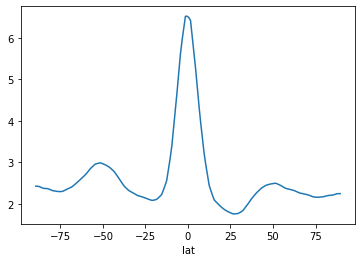

In [21]:
#Test what the correction looks like. Will need to take zonal mean
corr_wv_zm_dict['CAM3'].mean(dim='time').plot()

#Makes sense, the ITCZ is where the cloud masking is strongest

In [ ]:

#####   SURFACE TEMPERATURE KERNEL CORRECTION   #####


In [21]:
corr_ts_dict = dict()
numYears_dict = dict() #To hold the number of years for each model
kernel_ts = xr.open_dataarray('../aquakernels_Feldl/aquakernels/lw_ts_rg.nc')
kernel_ts_clr = xr.open_dataarray('../aquakernels_Feldl/aquakernels/lwclr_ts_rg.nc')

for model in models_10:
    print('Calculating surface temperature correction: ' + model)
    
    ds_mon_ts = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')
    numMonths = len(ds_mon_ts.time)
    numYears_dict[model] = int(numMonths/12)
    
    #Preallocate something to store the output after multiplication 
    dLW_ts = np.zeros([numMonths, len(ds_mon_ts.lat), len(ds_mon_ts.lon)]) 
    dLW_ts_clr = np.zeros([numMonths, len(ds_mon_ts.lat), len(ds_mon_ts.lon)]) 

    #Loop through the months
    for i in np.arange(numMonths):
        if i % 20 == 0:
            print('month '+str(i))
            
        #Subsets for month, etc.
        ts_clim_i = ds_clim_2D.sel(model=model).isel(time=i%12)['ts']
        ts_mon_i = ds_mon_ts.isel(time=i)['ts']
        kernel_i = kernel_ts.isel(time=i%12)
        kernel_clr_i = kernel_ts_clr.isel(time=i%12)

        #Calculate temperature difference
        dT_i = ts_mon_i - ts_clim_i
                
        #Multiply by kernel
        dLW_ts[i,:,:] = dT_i*kernel_i
        dLW_ts_clr[i,:,:] = dT_i*kernel_clr_i
        
    #Take difference for correction
    corr_ts = dLW_ts - dLW_ts_clr
        
    #Create XArray DataArray with the result
    corr_ts_dict[model] = xr.DataArray(corr_ts, coords=[ds_mon_ts.time, ds_clim_2D.lat, ds_clim_2D.lon],  
                                      dims=['time', 'lat', 'lon'], name='corr_ts')
    
    

Calculating surface temperature correction: AM2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Calculating surface temperature correction: CAM3
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Calculating surface temperature correction: CAM4
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Calculating surface temperature correction: ECHAM-6.1
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
mont

In [ ]:

#####   CO2 FORCING CORRECTION   #####


In [ ]:
#Where did I deal with this? 
#ApplyKernels_CloudLW

#Variable called "CO2_correction_zm_int", about 2/3 of the way down that script. 
#Didn't save to a NetCDF file. 

#Need to either copy the code that made that variable into here, or save to a 
#NetCDF from within the other script.

#I think the former strategy is better (makes this more self contained)


In [12]:
#Load CAM3 CO2 kernels (Shell et al., 2008) and calculate the cloud masking correction
kernel_CAM3_CO2 = xr.open_dataset('fromGeoMIP/kernelsShell/CAM3_CO2_lw_kernel.nc')
kernel_CAM3_CO2_clr = xr.open_dataset('fromGeoMIP/kernelsShell/CAM3_CO2_lw_clr_kernel.nc')

kernel_CAM3_cloud_masking_correction_CO2 = 2*(kernel_CAM3_CO2 - kernel_CAM3_CO2_clr)

#Zonal mean of cloud masking correction
CO2_correction_zm = kernel_CAM3_cloud_masking_correction_CO2.mean(dim='lon')

#Convert the "record" dimension to a "time" dimension
CO2_correction_zm_assign = CO2_correction_zm.assign_coords({'record': ds_clim_2D.time})
CO2_correction_zm_time = CO2_correction_zm_assign.rename_dims({'record': 'time'})

#Regrid to common latitude grid
CO2_correction_zm_int = CO2_correction_zm_time.interp(coords = {'time': CO2_correction_zm_time.time.data, 
                                                                'lat': ds_clim_2D.lat.data})

#Fill in edge nans with adjacent values
CO2_correction_zm_int['toaeffect'].loc[dict(lat=-89.5)] = CO2_correction_zm_int['toaeffect'].sel(lat=-87.5)
CO2_correction_zm_int['toaeffect'].loc[dict(lat=-88.5)] = CO2_correction_zm_int['toaeffect'].sel(lat=-87.5)
CO2_correction_zm_int['toaeffect'].loc[dict(lat=88.5)] = CO2_correction_zm_int['toaeffect'].sel(lat=87.5)
CO2_correction_zm_int['toaeffect'].loc[dict(lat=89.5)] = CO2_correction_zm_int['toaeffect'].sel(lat=87.5)

<xarray.Dataset>
Dimensions:    (lat: 180, time: 12)
Coordinates:
    exp        <U11 'AquaControl'
  * time       (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2006-12-01
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    toaeffect  (time, lat) float64 0.5314 0.5314 0.5314 ... 0.3386 0.3386 0.3386
(12, 180)


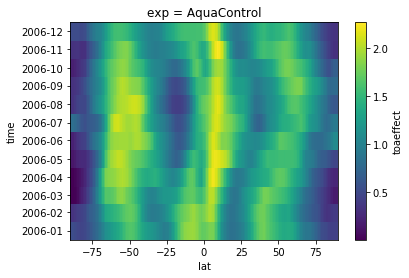

In [16]:
#Plot to make sure it looks right (yes, it does)
CO2_correction_zm_int['toaeffect'].plot()
print(CO2_correction_zm_int)
print(np.shape(CO2_correction_zm_int['toaeffect'].data))

In [ ]:
#Duplicate (np.tile) to match the times of the other monthly stuff
#Did this above: 
#LWCRE_cli_dupe = np.tile(LWCRE_cli_raw, (numYears,1))
#But, now need to worry about the fact that different 
#Better to do this in a loop over the models below

In [22]:
for model in models_10:
    print(numYears_dict[model])

40
40
40
45
40
30
40
40
40
40


In [23]:
#Naah, do it here:
corr_CO2_dict = dict()
for model in models_10:
    corr_CO2_dict[model] = np.tile(CO2_correction_zm_int['toaeffect'], (numYears_dict[model], 1))
    print(np.shape(corr_CO2_dict[model]))
    #OK, seems to have worked!

(480, 180)
(480, 180)
(480, 180)
(540, 180)
(480, 180)
(360, 180)
(480, 180)
(480, 180)
(480, 180)
(480, 180)


In [ ]:

#####   PUT EVERYTHING TOGETHER   #####


In [26]:
dLWCRE_co = dict()

save = True
if save:
    for model in models_10:         
        #Add all the corrections to the raw LWCRE change
        print('Applying cloud masking corrections: ' + model)
        dLWCRE_co[model] = dLWCRE_raw[model] + (corr_ta_zm_dict[model] + corr_wv_zm_dict[model] + 
                                                corr_ts_dict[model].mean(dim='lon') + corr_CO2_dict[model])
        
        #Save to NetCDF files
        dLWCRE_co[model].to_netcdf('nc_from_xarray/dLWCRE_co_monthly_'+model+'.nc')
        
else: #Load from NetCDF file
    for model in models_10: 
        dLWCRE_co[model] = xr.open_dataset('nc_from_xarray/dLWCRE_co_monthly_'+model+'.nc')

Applying cloud masking corrections: AM2


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Applying cloud masking corrections: CAM3
Applying cloud masking corrections: CAM4
Applying cloud masking corrections: ECHAM-6.1
Applying cloud masking corrections: ECHAM-6.3
Applying cloud masking corrections: IPSL-CM5A
Applying cloud masking corrections: MIROC5
Applying cloud masking corrections: MPAS
Applying cloud masking corrections: MetUM-GA6-CTL
Applying cloud masking corrections: MetUM-GA6-ENT


In [ ]:

#####   GREGORY REGRESSIONS   #####
#Wait--did this in "GregoryIndividualFeedbacks" script so do it there. 

In [ ]:

#####   PLOTS   #####


In [ ]:
#How about some time series plots of the raw and corrected change in LWCRE?

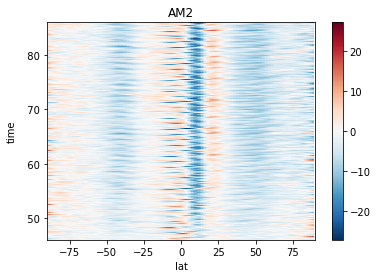

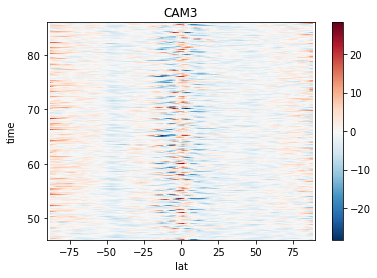

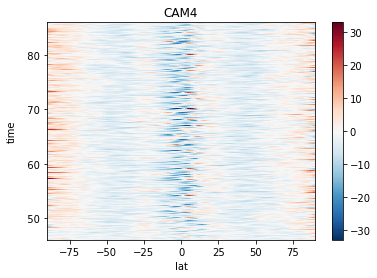

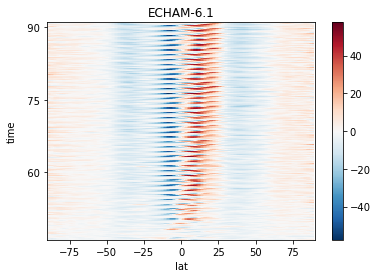

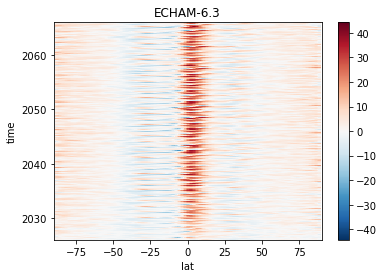

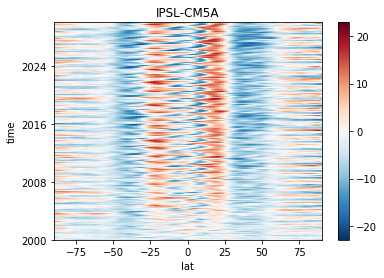

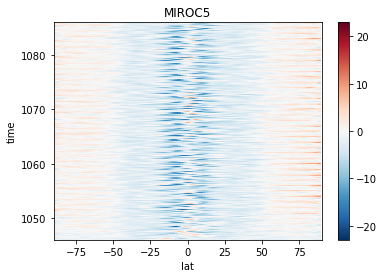

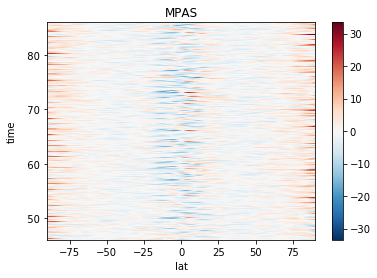

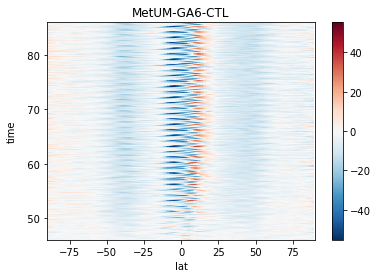

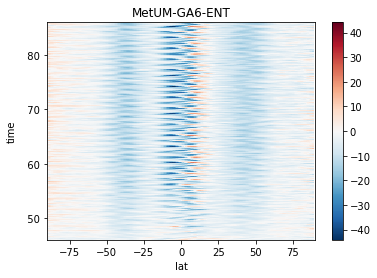

In [29]:
for model in models_10:
    plt.figure()
    dLWCRE_raw[model].plot()
    plt.title(model)

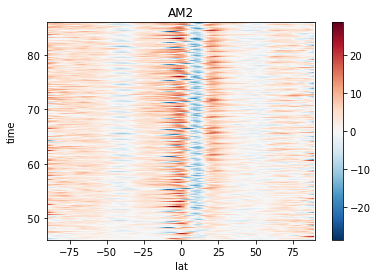

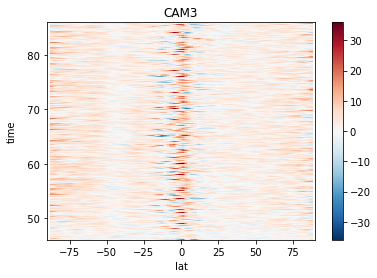

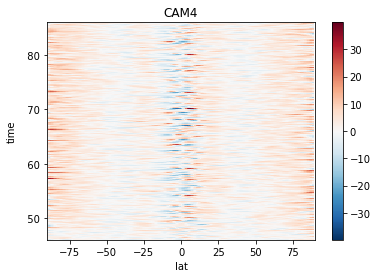

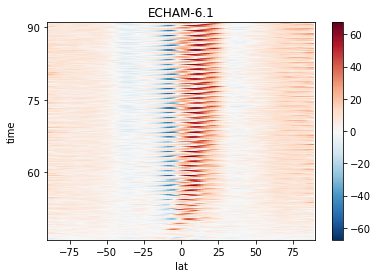

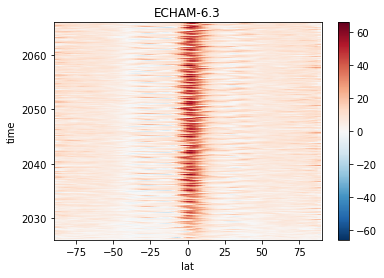

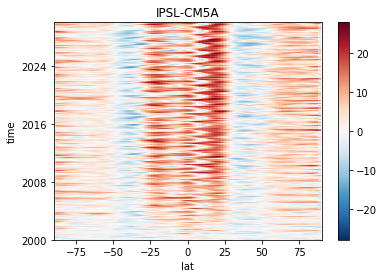

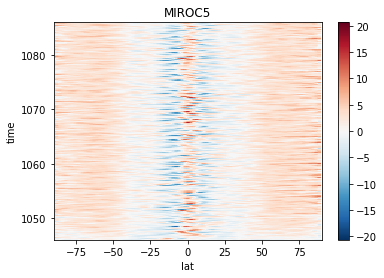

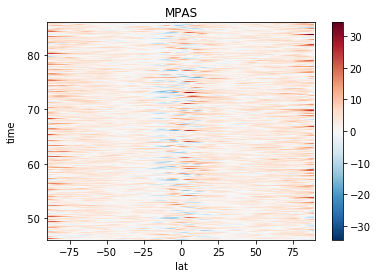

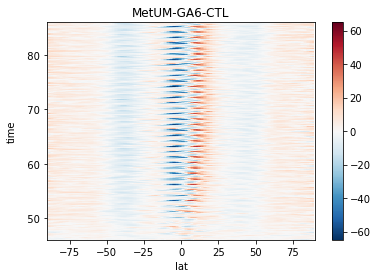

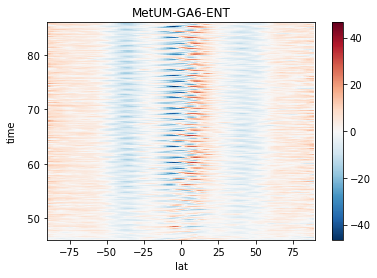

In [30]:
for model in models_10:
    plt.figure()
    dLWCRE_co[model].plot()
    plt.title(model)